In [44]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
lck_data = pd.read_csv('../Data/LCK_Tournament.csv')

In [15]:
# 1. Xử lý cột date để chỉ lấy ngày/tháng/năm
lck_data['date'] = pd.to_datetime(lck_data['date']).dt.date

# 2. Nhóm dữ liệu theo ngày và game_id để tìm các cặp đội đấu với nhau
matches = lck_data.groupby(['date', 'gameid']).agg({
    'teamname': lambda x: list(set(x))  # Lấy danh sách các đội unique trong mỗi game
}).reset_index()

# 3. Lọc ra các game có đúng 2 đội (để đảm bảo)
valid_matches = matches[matches['teamname'].apply(len) == 2]

# 4. Tạo match_id cho mỗi cặp đấu
valid_matches['match_id'] = valid_matches.apply(
    lambda row: f"{row['date']}_{sorted(row['teamname'])[0]}_vs_{sorted(row['teamname'])[1]}", 
    axis=1
)

# 5. Merge match_id trở lại dataframe gốc
match_mapping = valid_matches[['date', 'gameid', 'match_id']]
lck_data = lck_data.merge(match_mapping, on=['date', 'gameid'], how='left')


In [16]:
lck_data.to_csv('../Data/LCK_data(with matchid).csv')

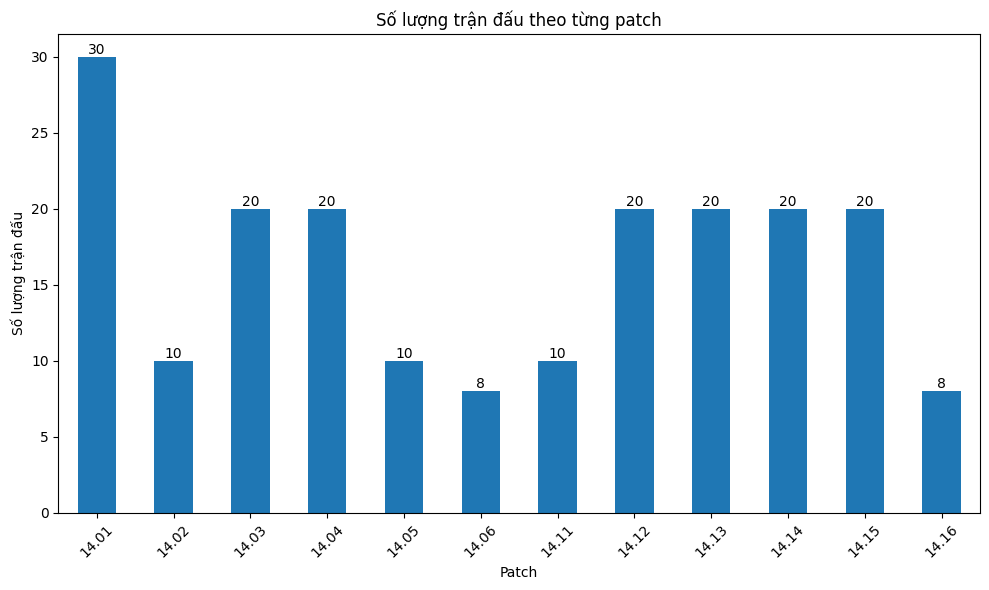

In [17]:
# Thống kê số lượng trận đấu matchid theo từng patch
matchid_per_patch = lck_data.groupby('patch')['match_id'].nunique()

# Trực quan hóa bằng biểu đồ cột
plt.figure(figsize=(10, 6))
ax = matchid_per_patch.plot(kind='bar')

# Thêm giá trị cụ thể lên mỗi cột
for i, v in enumerate(matchid_per_patch):
    ax.text(i, v, str(v), ha='center', va='bottom')
    
plt.title('Số lượng trận đấu theo từng patch')
plt.xlabel('Patch')
plt.ylabel('Số lượng trận đấu')
plt.xticks(rotation=45)
plt.tight_layout()  # Điều chỉnh layout để không bị cắt nhãn
plt.show()





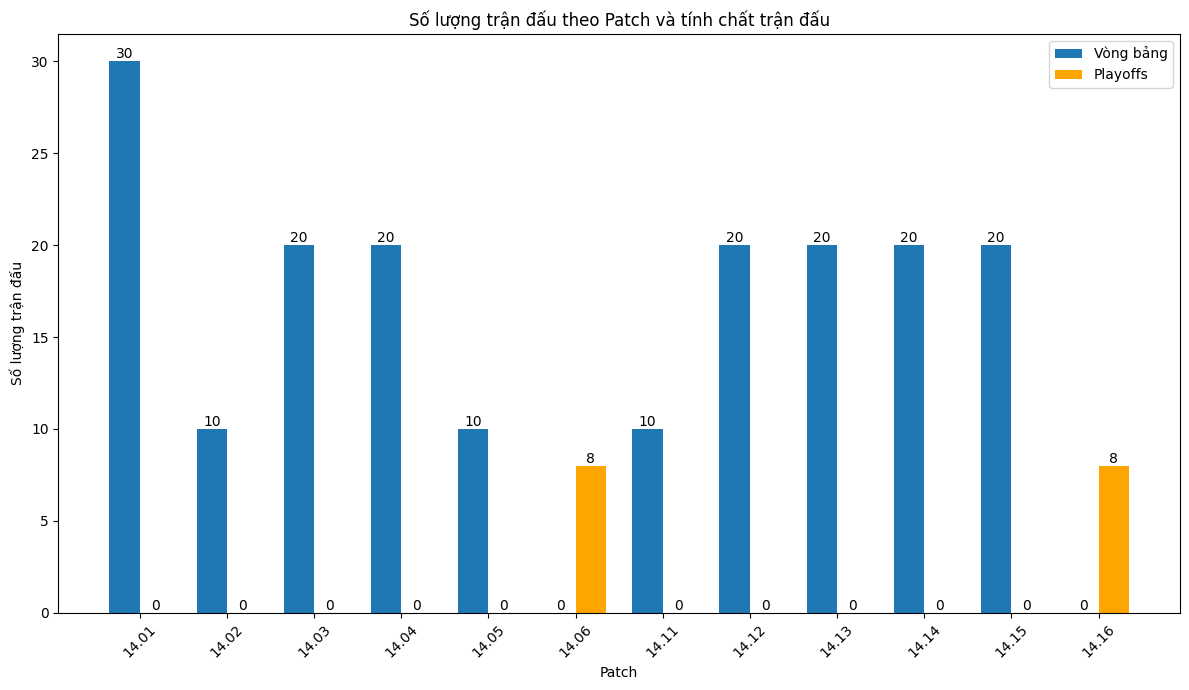

In [28]:
# Thống kê số lượng trận đấu theo patch và playoffs
matches_by_patch_playoffs = lck_data.groupby(['patch', 'playoffs'])['match_id'].nunique().unstack().fillna(0)

# Tạo figure với kích thước lớn hơn
plt.figure(figsize=(12, 7))

# Vẽ biểu đồ cột ghép
bar_width = 0.35
x = np.arange(len(matches_by_patch_playoffs.index))

# Vẽ cột cho regular season (playoffs=0)
regular = plt.bar(x - bar_width/2, matches_by_patch_playoffs[0], 
                 bar_width, label='Vòng bảng')

# Vẽ cột cho playoffs (playoffs=1)
playoffs = plt.bar(x + bar_width/2, matches_by_patch_playoffs[1], 
                  bar_width, label='Playoffs', color='orange')

# Thêm giá trị lên các cột
for i, v in enumerate(matches_by_patch_playoffs[0]):
    plt.text(i - bar_width/2, v, str(int(v)), ha='center', va='bottom')
    
for i, v in enumerate(matches_by_patch_playoffs[1]):
    plt.text(i + bar_width/2, v, str(int(v)), ha='center', va='bottom')

# Thiết lập các thuộc tính cho biểu đồ
plt.xlabel('Patch')
plt.ylabel('Số lượng trận đấu')
plt.title('Số lượng trận đấu theo Patch và tính chất trận đấu')
plt.xticks(x, matches_by_patch_playoffs.index, rotation=45)
plt.legend()

# Điều chỉnh layout
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

In [ ]:
# Đổi kiểu đữ liệu 'date'
lck_data.loc[:, 'date'] = pd.to_datetime(lck_data['date'])

# Tạo figure
plt.figure(figsize=(15, 7))

# Gom nhóm theo từng tuần
weekly_games = lck_data.groupby(pd.Grouper(key='date', freq='W')).size() // 2

# Loại bỏ các tuần không có trận đấu
weekly_games = weekly_games[weekly_games > 0]

# Tạo biểu đồ time-series
plt.plot(weekly_games.index, weekly_games.values, marker='o', linewidth=2)

# Điều chỉnh biểu đồ
plt.title('Số lượng ván đấu LCK theo tuần', pad=20, fontsize=14)
plt.xlabel('Tuần', fontsize=12)
plt.ylabel('Số ván đấu', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

# Thêm nhãn giá trị lên đầu mỗi điểm 
for x, y in zip(weekly_games.index, weekly_games.values):
    plt.annotate(str(int(y)), 
                (x, y),
                textcoords="offset points", 
                xytext=(0,-10), 
                ha='center',
                va='top')

plt.tight_layout()
plt.show()

# In thông số
print("\nThống kê theo tuần:")
print(f"Tổng số tuần thi đấu: {len(weekly_games)}")
print(f"Trung bình số trận mỗi tuần: {weekly_games.mean():.2f}")
print(f"Số trận nhiều nhất trong một tuần: {weekly_games.max()}")
print(f"Số trận ít nhất trong một tuần: {weekly_games.min()}")

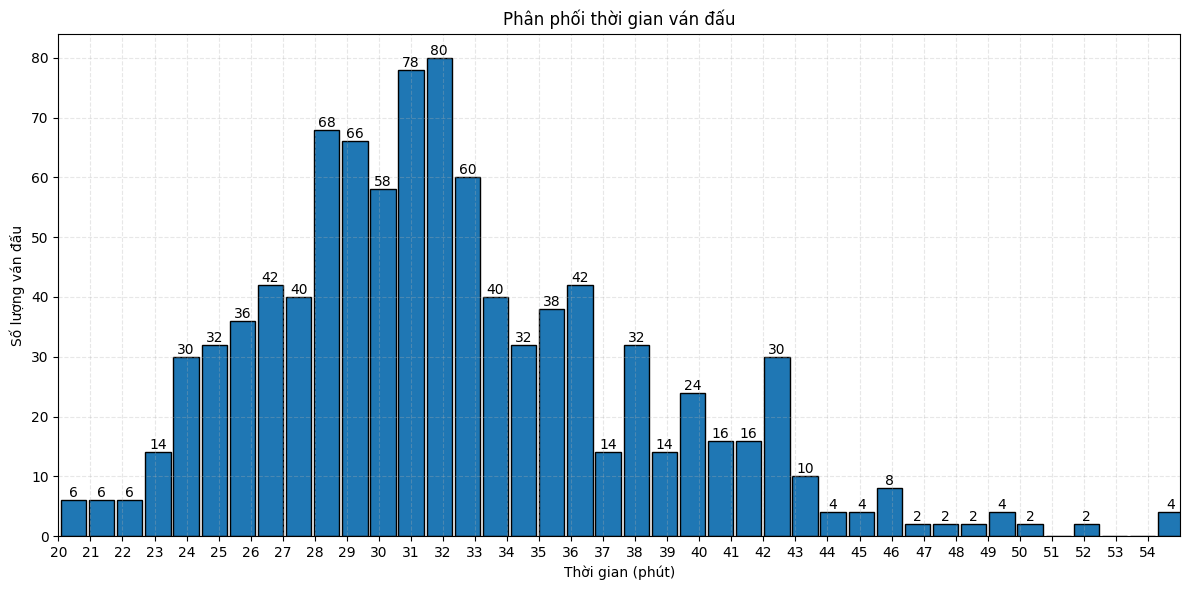


Thống kê thời gian ván đấu:
Trung bình: 32 phút 16 giây
Ngắn nhất: 20 phút 2 giây
Dài nhất: 55 phút 9 giây

Phân vị thời gian:
Phân vị 25%: 28 phút 24 giây
Phân vị 50%: 31 phút 27 giây
Phân vị 75%: 35 phút 30 giây

Thời gian phổ biến nhất: 32 phút 19 giây
Độ lệch chuẩn: 5 phút 51 giây


In [32]:
# Hàm chuyển đổi giây sang định dạng "X phút Y giây"
def format_time(seconds):
    minutes = seconds // 60
    remaining_seconds = seconds % 60
    return f"{int(minutes)} phút {int(remaining_seconds)} giây"

# Tạo figure với kích thước phù hợp
plt.figure(figsize=(12, 6))

# Tạo histogram với bins chi tiết hơn và thêm grid
counts, bins, patches = plt.hist(lck_data['gamelength']/60, 
                               bins=40,  # Tăng số lượng bins
                               edgecolor='black',
                               rwidth=0.9)  # Giảm độ rộng của bars để dễ nhìn

# Thêm grid để dễ đọc
plt.grid(True, alpha=0.3, linestyle='--')

# Điều chỉnh trục X
plt.xticks(np.arange(20, 55, 1))  # Đánh dấu mỗi 1 phút
plt.xlim(20, 55)  # Giới hạn trục X từ 20-55 phút

# Thêm nhãn giá trị lên đầu mỗi bar
for count, patch in zip(counts, patches):
    if count > 0:  # Chỉ hiển thị nhãn nếu có giá trị
        plt.text(patch.get_x() + patch.get_width()/2,
                count,
                int(count),
                ha='center',
                va='bottom')

plt.title('Phân phối thời gian ván đấu')
plt.xlabel('Thời gian (phút)')
plt.ylabel('Số lượng ván đấu')
plt.tight_layout()
plt.show()


# In thống kê với định dạng thời gian mới
print("\nThống kê thời gian ván đấu:")
mean_time = format_time(lck_data['gamelength'].mean())
min_time = format_time(lck_data['gamelength'].min())
max_time = format_time(lck_data['gamelength'].max())

print(f"Trung bình: {mean_time}")
print(f"Ngắn nhất: {min_time}")
print(f"Dài nhất: {max_time}")

# Thêm phân tích phân vị
percentiles = [25, 50, 75]
print("\nPhân vị thời gian:")
for p in percentiles:
    time_p = format_time(np.percentile(lck_data['gamelength'], p))
    print(f"Phân vị {p}%: {time_p}")

# Tính mode (thời gian phổ biến nhất)
mode_time = format_time(lck_data['gamelength'].mode().iloc[0])
print(f"\nThời gian phổ biến nhất: {mode_time}")

# Tính độ lệch chuẩn
std_time = format_time(lck_data['gamelength'].std())
print(f"Độ lệch chuẩn: {std_time}")

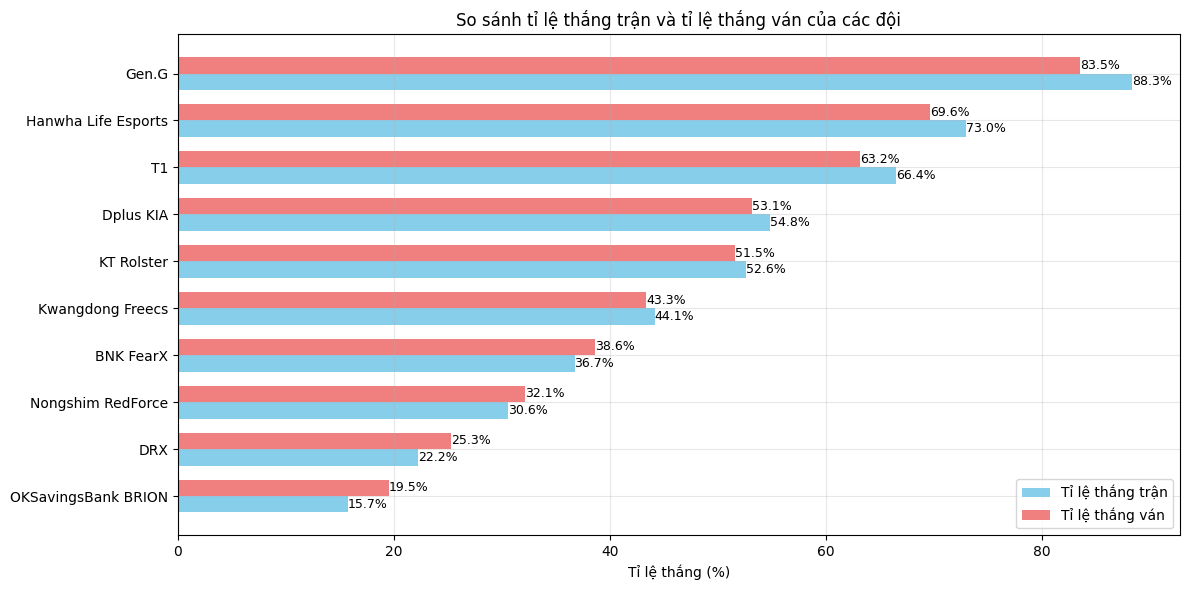


Thống kê chi tiết:
Tên đội              Tỉ lệ thắng trận     Tỉ lệ thắng ván      Chênh lệch          
--------------------------------------------------------------------------------
OKSavingsBank BRION    15.7%                19.5%                -3.8%
DRX                    22.2%                25.3%                -3.1%
Nongshim RedForce      30.6%                32.1%                -1.6%
BNK FearX              36.7%                38.6%                -1.9%
Kwangdong Freecs       44.1%                43.3%                 0.8%
KT Rolster             52.6%                51.5%                 1.0%
Dplus KIA              54.8%                53.1%                 1.6%
T1                     66.4%                63.2%                 3.3%
Hanwha Life Esports    73.0%                69.6%                 3.3%
Gen.G                  88.3%                83.5%                 4.8%


In [41]:
# 1. Tính tỉ lệ thắng ván đấu (game)
team_stats = lck_data.groupby('teamname').agg({
    'match_id': 'count',
    'result': 'mean'
}).reset_index()
team_stats['win_rate'] = (team_stats['result'] * 100).round(2)

# 2. Tính tỉ lệ thắng trận đấu (match)
match_results = lck_data.groupby(['match_id', 'teamname'])['result'].mean().reset_index()
match_stats = match_results.groupby('teamname').agg({
    'match_id': 'count',
    'result': 'mean'
}).reset_index()
match_stats['match_win_rate'] = (match_stats['result'] * 100).round(2)

# 3. Kết hợp hai bảng thống kê
match_stats = match_stats.merge(team_stats[['teamname', 'win_rate']], on='teamname')
match_stats = match_stats.sort_values('match_win_rate', ascending=True)


# Vẽ biểu đồ so sánh
plt.figure(figsize=(12, 6))

# Vẽ 2 thanh cho mỗi đội
x = np.arange(len(match_stats))
width = 0.35

plt.barh(x - width/2, match_stats['match_win_rate'], width, 
         label='Tỉ lệ thắng trận', color='skyblue')
plt.barh(x + width/2, match_stats['win_rate'], width, 
         label='Tỉ lệ thắng ván', color='lightcoral')

# Thêm giá trị lên mỗi thanh
for i, v in enumerate(match_stats['match_win_rate']):
    plt.text(v, i - width/2, f'{v:.1f}%', 
             ha='left', va='center', fontsize=9)
for i, v in enumerate(match_stats['win_rate']):
    plt.text(v, i + width/2, f'{v:.1f}%', 
             ha='left', va='center', fontsize=9)

plt.yticks(x, match_stats['teamname'])
plt.xlabel('Tỉ lệ thắng (%)')
plt.title('So sánh tỉ lệ thắng trận và tỉ lệ thắng ván của các đội')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# In thống kê chi tiết
print("\nThống kê chi tiết:")
print("Tên đội".ljust(20), "Tỉ lệ thắng trận".ljust(20), "Tỉ lệ thắng ván".ljust(20), "Chênh lệch".ljust(20))
print("-" * 80)
for _, row in match_stats.iterrows():
    diff = row['match_win_rate'] - row['win_rate']
    print(f"{row['teamname']:<20} {row['match_win_rate']:>6.1f}%{' ':13} {row['win_rate']:>6.1f}%{' ':13} {diff:>6.1f}%")

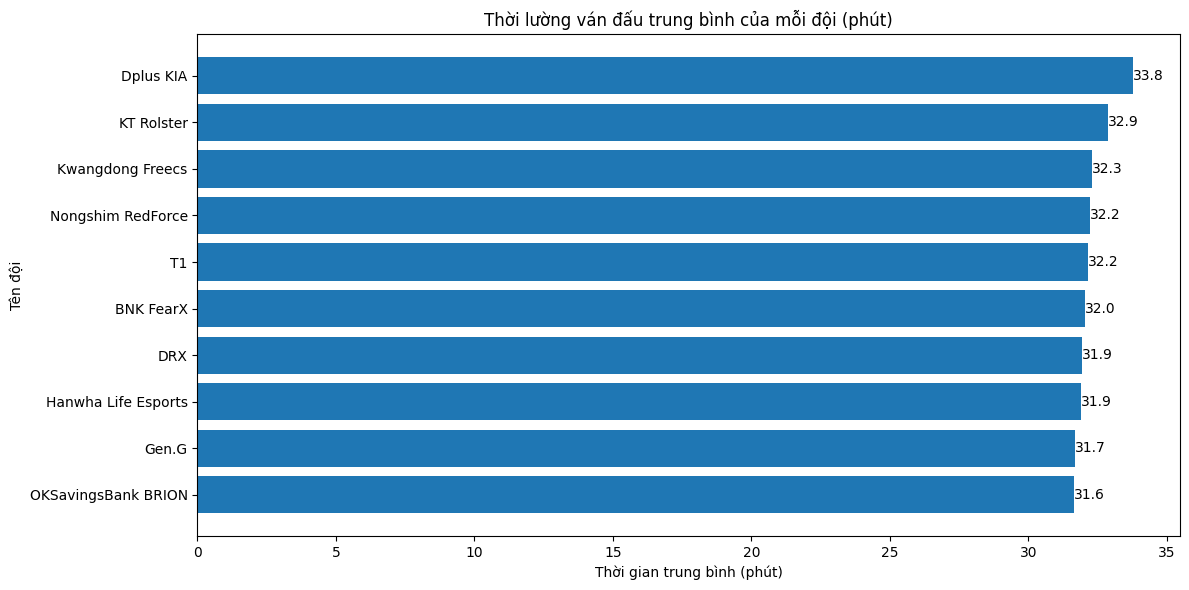

In [38]:
# Phân tích thời gian trận đấu trung bình của mỗi đội
avg_game_length = lck_data.groupby('teamname')['gamelength'].mean().sort_values(ascending=True)
avg_game_length = avg_game_length / 60  # Chuyển đổi sang phút

plt.figure(figsize=(12, 6))
bars = plt.barh(avg_game_length.index, avg_game_length)
plt.title('Thời lường ván đấu trung bình của mỗi đội (phút)')
plt.xlabel('Thời gian trung bình (phút)')
plt.ylabel('Tên đội')

# Thêm giá trị lên mỗi thanh
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}', 
             ha='left', va='center', fontsize=10)
plt.tight_layout()
plt.show()


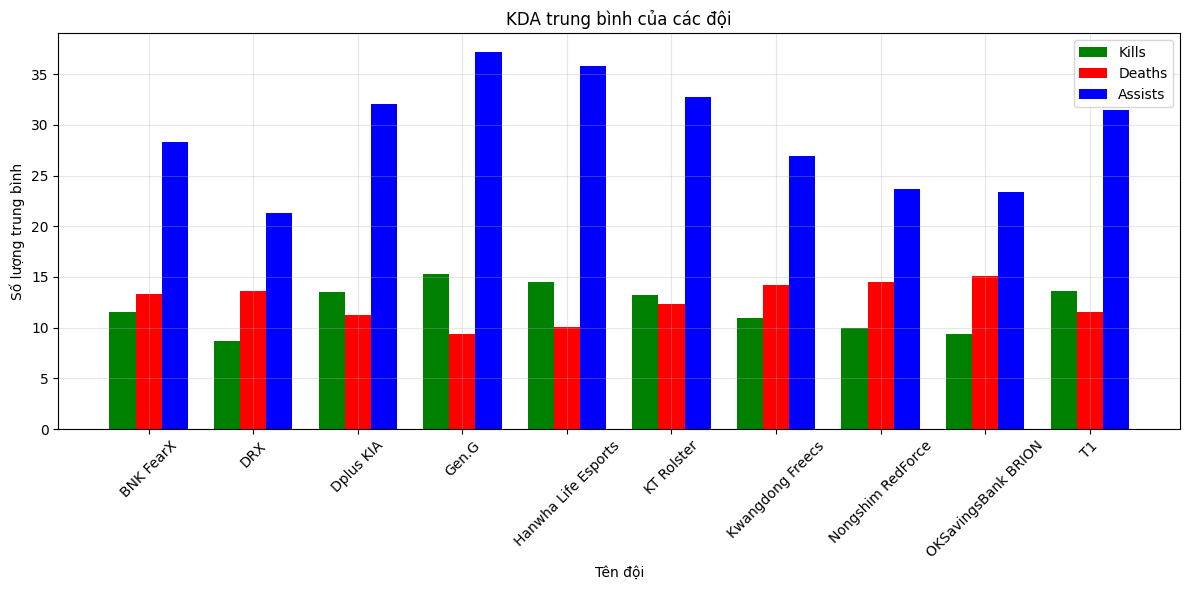

In [42]:
# Tính KDA trung bình của mỗi đội
team_kda = lck_data.groupby('teamname').agg({
    'kills': 'mean',
    'deaths': 'mean', 
    'assists': 'mean'
}).round(2)

# Vẽ biểu đồ cột ghép
plt.figure(figsize=(12, 6))
x = np.arange(len(team_kda.index))
width = 0.25

plt.bar(x - width, team_kda['kills'], width, label='Kills', color='green')
plt.bar(x, team_kda['deaths'], width, label='Deaths', color='red')
plt.bar(x + width, team_kda['assists'], width, label='Assists', color='blue')

plt.title('KDA trung bình của các đội')
plt.xlabel('Tên đội')
plt.ylabel('Số lượng trung bình')
plt.xticks(x, team_kda.index, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

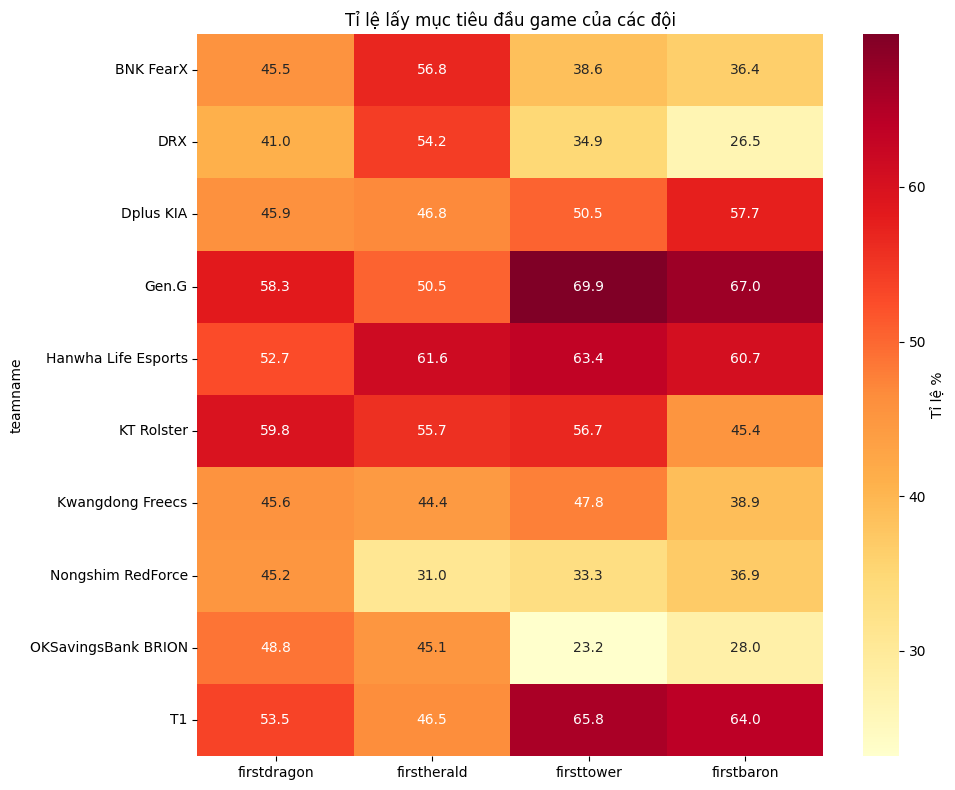

In [45]:
# Tính tỉ lệ lấy các mục tiêu đầu game
first_objectives = lck_data.groupby('teamname').agg({
    'firstdragon': 'mean',
    'firstherald': 'mean',
    'firsttower': 'mean',
    'firstbaron': 'mean'
}) * 100

# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(first_objectives, 
            annot=True, 
            fmt='.1f',
            cmap='YlOrRd',
            cbar_kws={'label': 'Tỉ lệ %'})
plt.title('Tỉ lệ lấy mục tiêu đầu game của các đội')
plt.tight_layout()
plt.show()

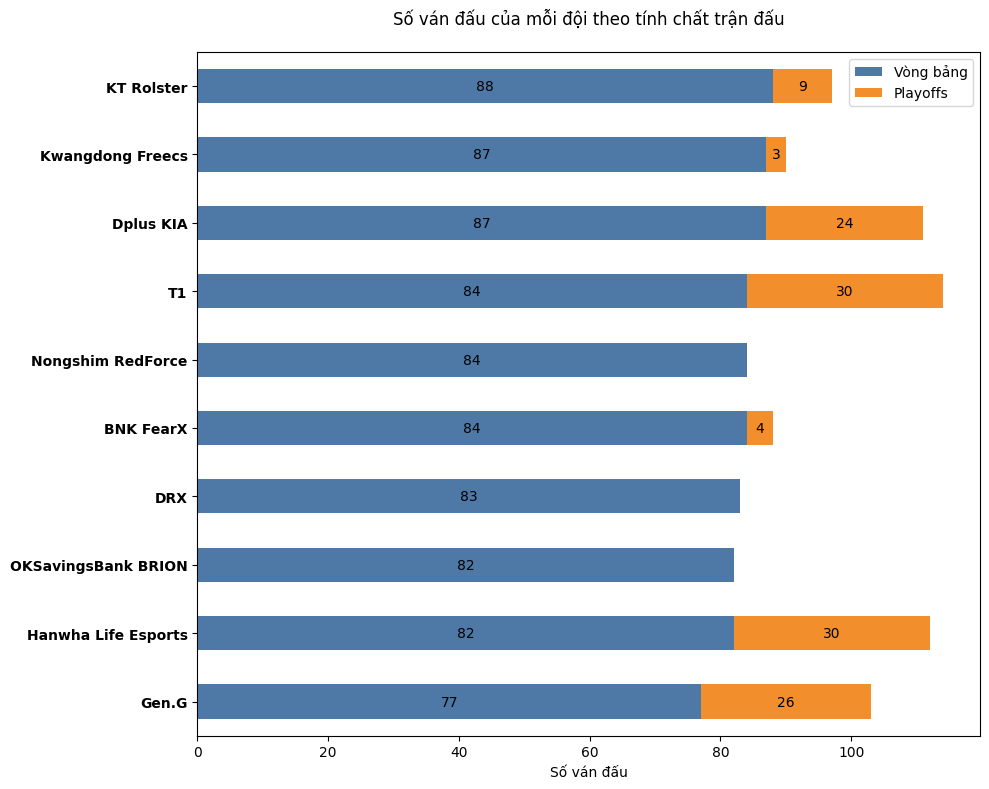

In [54]:
# Tạo DataFrame thống kê số trận theo đội và playoffs
team_playoff_counts = pd.crosstab(lck_data['teamname'], lck_data['playoffs'])
team_playoff_counts.columns = ['Vòng bảng', 'Playoffs']  # Đổi tên cột cho dễ hiểu
team_playoff_counts = team_playoff_counts.sort_values('Vòng bảng', ascending=True)  # Sắp xếp theo số trận vòng bảng

# Tạo biểu đồ
fig, ax = plt.subplots(figsize=(10, 8))
bars = team_playoff_counts.plot(kind='barh', ax=ax, stacked=True, 
                              color=['#4e79a7', '#f28e2b'])

# Chỉnh sửa biểu đồ
ax.set_title('Số ván đấu của mỗi đội theo tính chất trận đấu', pad=20)
ax.set_xlabel('Số ván đấu')
ax.set_ylabel('') 
ax.set_yticklabels(ax.get_yticklabels(), weight='bold')
ax.legend(title='')

# Thêm nhãn giá trị vào mỗi phần của thanh
for i in range(len(team_playoff_counts)):
    # Vòng bảng
    regular_matches = team_playoff_counts.iloc[i, 0]
    if regular_matches > 0:
        ax.text(regular_matches/2, i, str(regular_matches),
                ha='center', va='center', color='black')
    
    # Playoffs
    playoff_matches = team_playoff_counts.iloc[i, 1]
    if playoff_matches > 0:
        ax.text(regular_matches + playoff_matches/2, i, str(playoff_matches),
                ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

In [68]:
lck_data = pd.read_csv("../Data/LCK_data(with matchid).csv")

In [70]:
# Lấy dữ liệu playoffs
playoffs_data = lck_data[lck_data['playoffs'] == True]

# Tạo DataFrame con với thông tin chi tiết
playoff_details = playoffs_data.groupby('match_id']).agg({
    'result': lambda x: (x == 1).sum(),  # Số ván thắng (result = 1)
}).reset_index()

# Thêm cột số ván thua (result = 0)
playoff_details['Số ván thua'] = playoffs_data.groupby('teamname')['result'].apply(lambda x: (x == 0).sum()).values

# Đổi tên cột cho dễ hiểu
playoff_details = playoff_details.rename(columns={
    'teamname': 'Tên đội',
    'result': 'Số ván thắng'
})



ValueError: Length of values (7) does not match length of index (32)

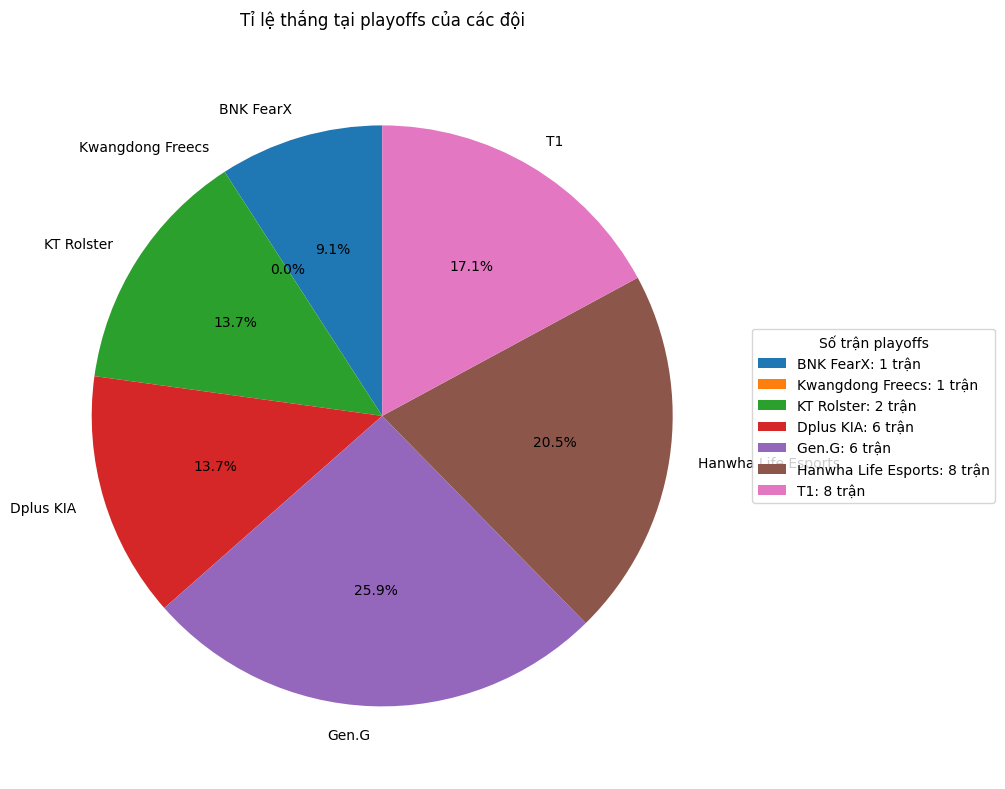

In [59]:
# Lấy dữ liệu playoffs
playoffs_data = lck_data[lck_data['playoffs'] == True]

# Tính số trận thắng và số trận thua của mỗi đội
playoff_stats = playoffs_data.groupby('teamname').agg({
    'match_id': 'nunique',  # Tổng số trận
    'result': lambda x: x[x == 1].count(),  # Số trận thắng (result = 1 là thắng)
    'result': lambda x: x[x == 0].count()   # Số trận thua (result = 0 là thua)
})

# Tính tỉ lệ thắng
playoff_stats['win_rate'] = (playoff_stats['result'] / playoff_stats['match_id'] * 100).round(1)

# Sắp xếp và lọc các đội có trận playoffs
playoff_stats = playoff_stats[playoff_stats['match_id'] > 0].sort_values('match_id', ascending=True)

# Vẽ biểu đồ tròn với tỉ lệ thắng
plt.figure(figsize=(12, 8))
plt.pie(playoff_stats['win_rate'], 
        labels=playoff_stats.index, 
        autopct='%1.1f%%',
        startangle=90)
plt.title('Tỉ lệ thắng tại playoffs của các đội', pad=20)

# Thêm chú thích với số trận cụ thể
plt.legend(labels=[f'{team}: {matches} trận' 
                  for team, matches in playoff_stats['match_id'].items()],
          title="Số trận playoffs",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

## Ban/pick

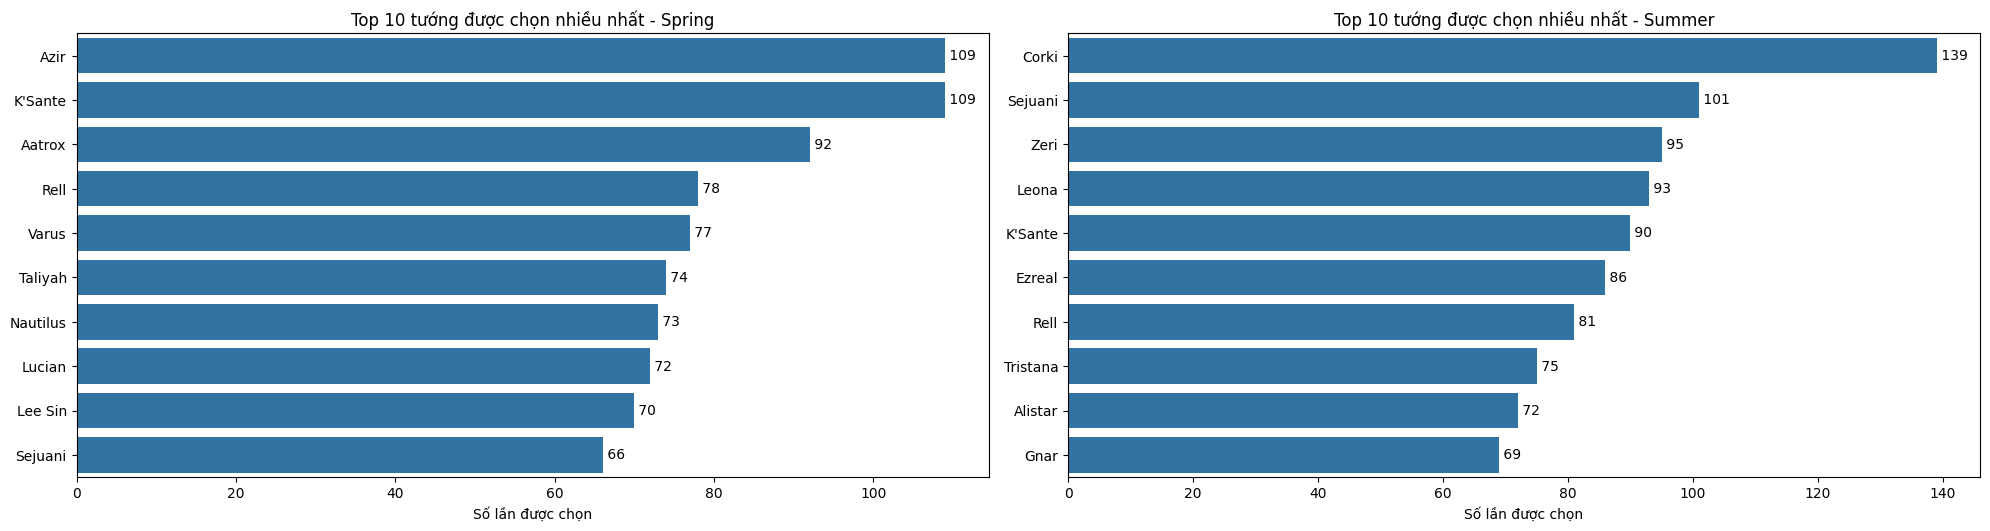

In [48]:
# Tạo figure với kích thước lớn hơn để chứa các subplots
plt.figure(figsize=(20, 10))

# Lấy danh sách các mùa giải unique
splits = sorted(lck_data['split'].unique())

# Tạo subplot cho mỗi mùa giải
for idx, split in enumerate(splits, 1):
    # Lọc dữ liệu cho mùa giải hiện tại
    split_data = lck_data[lck_data['split'] == split]
    
    # Gộp tất cả các lượt chọn cho mùa này
    split_picks = pd.concat([split_data[pick] for pick in ['pick1', 'pick2', 'pick3', 'pick4', 'pick5']])
    pick_counts = split_picks.value_counts().head(10)
    
    # Tạo subplot
    plt.subplot(2, 2, idx)
    
    # Vẽ barplot với màu khác để phân biệt với bans
    sns.barplot(x=pick_counts.values, y=pick_counts.index)
    
    # Chỉnh sửa subplot
    plt.title(f"Top 10 tướng được chọn nhiều nhất - {split}")
    plt.xlabel("Số lần được chọn")
    plt.ylabel('')
    
    # Thêm giá trị vào cuối mỗi thanh
    for i, v in enumerate(pick_counts.values):
        plt.text(v, i, f' {int(v)}', va='center')

# Điều chỉnh layout để tránh việc chồng chéo
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()


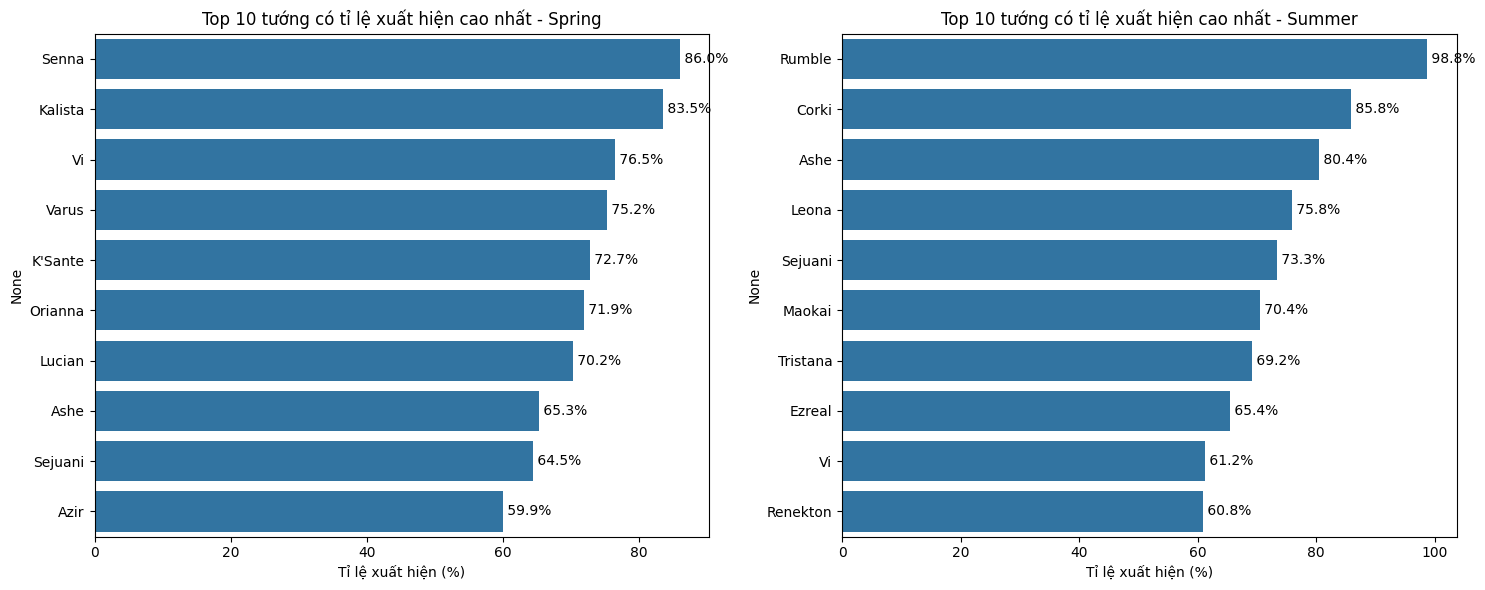


Thống kê chi tiết:

Spring Split:
Senna           86.0%
Kalista         83.5%
Vi              76.5%
Varus           75.2%
K'Sante         72.7%
Orianna         71.9%
Lucian          70.2%
Ashe            65.3%
Sejuani         64.5%
Azir            59.9%

Summer Split:
Rumble          98.8%
Corki           85.8%
Ashe            80.4%
Leona           75.8%
Sejuani         73.3%
Maokai          70.4%
Tristana        69.2%
Ezreal          65.4%
Vi              61.2%
Renekton        60.8%


In [51]:
# Tạo hàm tính tỉ lệ xuất hiện cho mỗi mùa
def calculate_presence_rate(split_data):
    # Số trận đấu trong mùa
    total_games = split_data['gameid'].nunique()
    
    # Gộp tất cả các lượt pick và ban
    all_picks = pd.concat([
        split_data[f'pick{i}'] for i in range(1, 6)
    ])
    all_bans = pd.concat([
        split_data[f'ban{i}'] for i in range(1, 6)
    ])
    
    # Gộp picks và bans
    all_appearances = pd.concat([all_picks, all_bans])
    
    # Đếm số lần xuất hiện của mỗi tướng
    champion_counts = all_appearances.value_counts()
    
    # Tính tỉ lệ xuất hiện (presence rate)
    presence_rate = (champion_counts / total_games * 100).round(2)
    
    return presence_rate.head(10)

# Tính tỉ lệ cho mỗi mùa
spring_presence = calculate_presence_rate(lck_data[lck_data['split'] == 'Spring'])
summer_presence = calculate_presence_rate(lck_data[lck_data['split'] == 'Summer'])

# Vẽ biểu đồ so sánh
plt.figure(figsize=(15, 6))

# Subplot cho Spring
plt.subplot(1, 2, 1)
sns.barplot(x=spring_presence.values, y=spring_presence.index)
plt.title('Top 10 tướng có tỉ lệ xuất hiện cao nhất - Spring')
plt.xlabel('Tỉ lệ xuất hiện (%)')
for i, v in enumerate(spring_presence.values):
    plt.text(v, i, f' {v:.1f}%', va='center')

# Subplot cho Summer
plt.subplot(1, 2, 2)
sns.barplot(x=summer_presence.values, y=summer_presence.index)
plt.title('Top 10 tướng có tỉ lệ xuất hiện cao nhất - Summer')
plt.xlabel('Tỉ lệ xuất hiện (%)')
for i, v in enumerate(summer_presence.values):
    plt.text(v, i, f' {v:.1f}%', va='center')

plt.tight_layout()
plt.show()

# In thống kê chi tiết
print("\nThống kê chi tiết:")
print("\nSpring Split:")
for champ, rate in spring_presence.items():
    print(f"{champ:<15} {rate:.1f}%")

print("\nSummer Split:")
for champ, rate in summer_presence.items():
    print(f"{champ:<15} {rate:.1f}%")

In [52]:
def calculate_champion_presence(df, champion):
    """
    Tính tỉ lệ xuất hiện của một tướng trong dataset
    """
    # Gộp tất cả picks và bans
    all_picks = pd.concat([df[f'pick{i}'] for i in range(1, 6)])
    all_bans = pd.concat([df[f'ban{i}'] for i in range(1, 6)])
    all_appearances = pd.concat([all_picks, all_bans])
    
    # Tính tỉ lệ xuất hiện
    total_games = len(df) // 2  # Chia 2 vì mỗi trận có 2 bản ghi
    appearances = (all_appearances == champion).sum()
    return (appearances / total_games * 100).round(1)

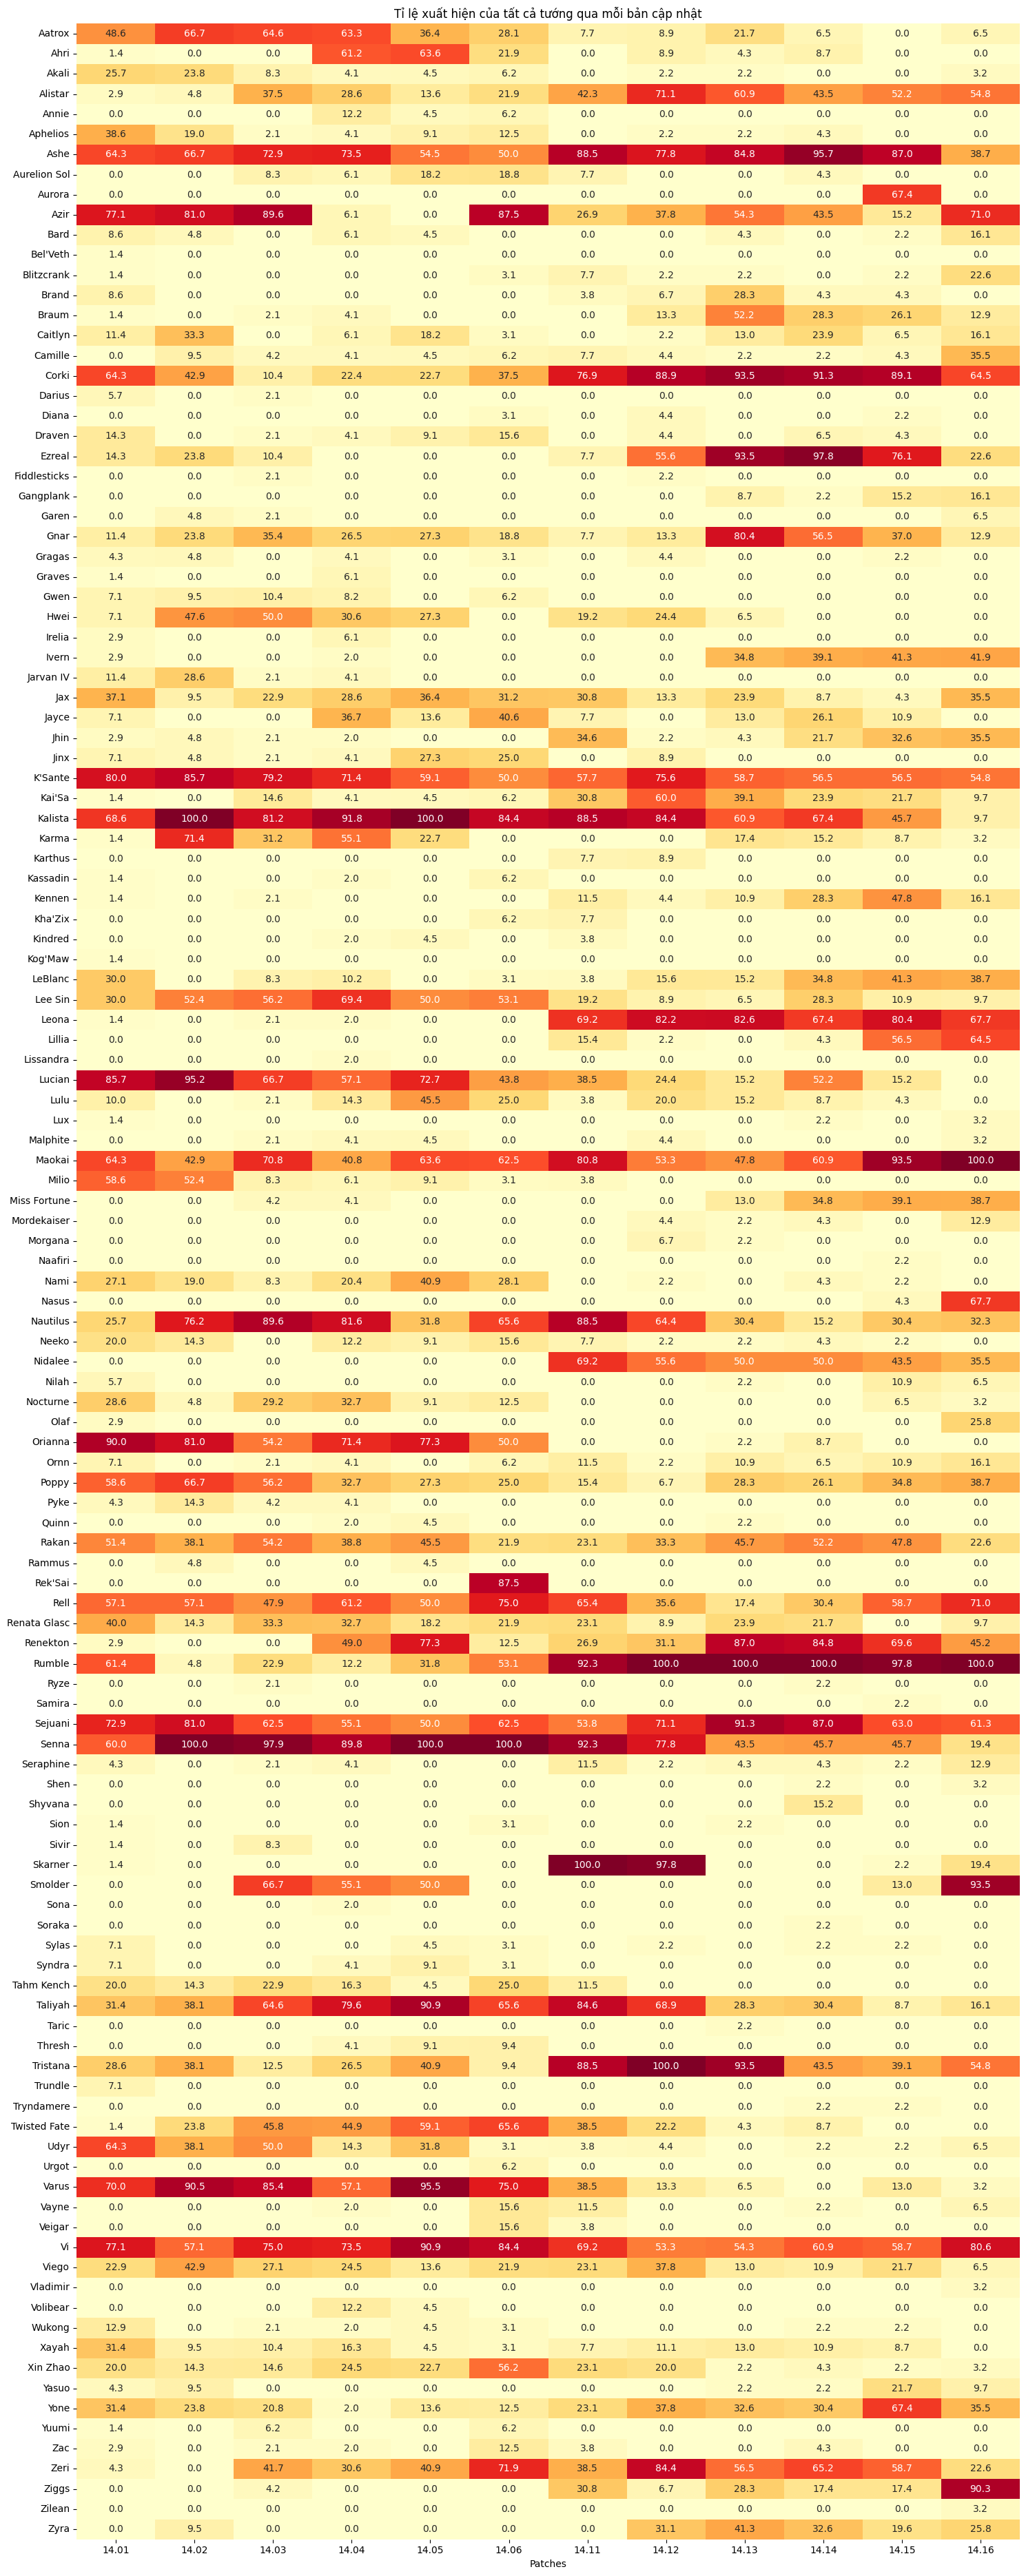

In [53]:
# Lấy danh sách các patch
patches = sorted(lck_data['patch'].unique())

# Lấy danh sách tất cả các tướng xuất hiện trong dataset
all_champions = set()
for i in range(1, 6):
    all_champions.update(lck_data[f'pick{i}'].unique())
    all_champions.update(lck_data[f'ban{i}'].unique())
all_champions = sorted(list(all_champions - {None, np.nan}))  # Loại bỏ các giá trị null

# Tính tỉ lệ xuất hiện cho mỗi tướng ở mỗi patch
heat_data = np.zeros((len(all_champions), len(patches)))

for i, champion in enumerate(all_champions):
    for j, patch in enumerate(patches):
        patch_data = lck_data[lck_data['patch'] == patch]
        heat_data[i, j] = calculate_champion_presence(patch_data, champion)

# Vẽ heatmap
plt.figure(figsize=(15, len(all_champions) * 0.3))  # Điều chỉnh kích thước theo số lượng tướng
sns.heatmap(heat_data,
            xticklabels=patches,
            yticklabels=all_champions,
            cmap='YlOrRd',
            annot=True,
            fmt='.1f',
            cbar=False,
            vmin=0,
            vmax=100)

plt.title("Tỉ lệ xuất hiện của tất cả tướng qua mỗi bản cập nhật")
plt.xlabel("Patches")
plt.ylabel("")

# Điều chỉnh layout để tránh bị cắt
plt.tight_layout()
plt.show()